# Link Prediction

In [50]:
import pandas
import seaborn
import numpy
import matplotlib.pyplot as plt

from sklearn import linear_model, metrics, model_selection, svm, preprocessing, neural_network, pipeline

pandas.set_option("display.max_columns", 101)
pandas.set_option('display.float_format', '{:.2f}'.format)

In [51]:
data = pandas.read_csv("data/p1p2Corona.csv")

- [1.About the data](#1.About-the-data)
- [2.Data cleanup](#2.Data-Cleanup)
- [3.Create test and train set](#3.Create-test-and-train-set)
- [4.Linear Regression](#4.Linear-Regression)
- [5.ElasticNet with Cross Validation](#5.ElasticNet-with-Cross-Validation)
- [6.Neural Network Regression](#6.Neural-Network-Regression)

## 1.About the data

We first check how many rows and columns we have. 

In [52]:
print(f"Rows:\t\t{data.shape[0]}\nColumns:\t{data.shape[1]}")

Rows:		166329
Columns:	48


What about data types? 

In [53]:
data.columns = data.columns.str.replace("`", "").str.replace(".", "")
data.dtypes

rweight                            int64
ID(p1)                             int64
p1averagedocyear                 float64
p1betweennesscentrality          float64
p1pagerank                       float64
p1COAUTHORcommunitylouvainall      int64
p1authoraffiliationname           object
p1originalaffiliationname         object
p1authormsaid                      int64
p1estimatedtotalcitations          int64
p1normauthorname                  object
p1lastknownaffiliation            object
p1totalcitations                   int64
p1positioninauthorlist             int64
p1idlastknownaffiliation         float64
p1authoraffiliationid            float64
p1defaultid                        int64
p1totalpublications                int64
p1originalauthorname              object
p1noorgorcoauthorperson          float64
p1suspicious                     float64
ID(p2)                             int64
p2averagedocyear                 float64
p2betweennesscentrality          float64
p2pagerank      

Basic stats

In [54]:
data.describe()

,rweight,ID(p1),p1averagedocyear,p1betweennesscentrality,p1pagerank,p1COAUTHORcommunitylouvainall,p1authormsaid,p1estimatedtotalcitations,p1totalcitations,p1positioninauthorlist,p1idlastknownaffiliation,p1authoraffiliationid,p1defaultid,p1totalpublications,p1noorgorcoauthorperson,p1suspicious,ID(p2),p2averagedocyear,p2betweennesscentrality,p2pagerank,p2COAUTHORcommunitylouvainall,p2authormsaid,p2estimatedtotalcitations,p2totalcitations,p2positioninauthorlist,p2idlastknownaffiliation,p2authoraffiliationid,p2defaultid,p2totalpublications,p2noorgorcoauthorperson,p2suspicious,adamicAdarscore,commonNeighborsscore,preferentialAttachmentscore,resourceAllocationscore,totalNeighborsscore,scorecommunitylouvainall,topicsimilarity
count,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00,133028.00,93761.00,166329.00,166329.00,0.00,0.00,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00,126239.00,91652.00,166329.00,166329.00,0.00,0.00,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00,166329.00
mean,1.25,9602.68,2010.12,212452.92,2.21,12449.13,2313166345.15,4349.05,3141.80,7.14,528778051.07,523430111.36,2313166345.15,78.16,nan,nan,13332.01,2010.14,138274.75,1.61,12546.78,2379175699.22,3481.15,2487.74,10.26,527309872.54,515541346.48,2379175699.22,63.36,nan,nan,4.98,16.64,2412.12,0.68,56.00,0.94,0.53
std,0.99,8428.09,7.35,937849.26,3.44,7980.30,561476884.80,11747.42,8418.45,7.71,753899480.52,738662251.16,561476884.80,190.34,nan,nan,9068.08,7.55,774374.37,2.72,7951.81,536565982.55,11310.81,7771.72,9.86,750631649.99,729359661.77,536565982.55,168.64,nan,nan,3.41,15.00,8923.39,0.31,79.89,0.24,0.39
min,1.00,11.00,1970.00,0.00,0.18,298.00,525113.00,0.00,0.00,1.00,46017.00,52325.00,525113.00,1.00,nan,nan,12.00,1970.00,0.00,0.17,298.00,525113.00,0.00,0.00,1.00,46017.00,52325.00,525113.00,1.00,nan,nan,0.00,0.00,1.00,0.00,2.00,0.00,0.00
25%,1.00,1930.00,2005.00,0.00,0.93,5502.00,2113892282.00,36.00,35.00,2.00,74801974.00,72212903.00,2113892282.00,3.00,nan,nan,6484.00,2005.00,0.00,0.75,5502.00,2129270150.00,19.00,19.00,4.00,72212903.00,66837359.50,2129270150.00,2.00,nan,nan,2.79,7.00,121.00,0.50,13.00,1.00,0.16
50%,1.00,7370.00,2010.29,0.50,1.06,12495.00,2306139023.00,438.00,343.00,5.00,157773358.00,157536573.00,2306139023.00,17.00,nan,nan,12777.00,2010.08,0.00,0.97,12644.00,2478031315.00,212.00,173.00,7.00,157773358.00,157536573.00,2478031315.00,9.00,nan,nan,4.00,12.00,440.00,0.70,26.00,1.00,0.44
75%,1.00,15504.00,2016.00,28928.00,1.94,18517.00,2671671651.00,3291.00,2405.00,9.00,889458895.00,889458895.00,2671671651.00,78.00,nan,nan,19191.00,2017.00,1453.87,1.24,18517.00,2716000858.00,1952.00,1477.00,13.00,912377674.00,901861585.00,2716000858.00,57.00,nan,nan,6.11,20.00,1800.00,0.85,65.00,1.00,1.00
max,56.00,61669.00,2020.00,13119691.78,31.65,29384.00,3010639452.00,375086.00,258534.00,67.00,3004594783.00,2898336195.00,3010639452.00,5332.00,nan,nan,61670.00,2020.00,13119691.78,31.65,29384.00,3010639452.00,375086.00,258534.00,67.00,3004594783.00,2898336195.00,3010639452.00,5332.00,nan,nan,83.47,257.00,649368.00,13.00,936.00,1.00,1.00


## 2.Data Cleanup

We will drop:
- Columns with "duplicate" information.
- Columns containing only `Nan`.

In [55]:
columns_to_drop = ["p1originalaffiliationname",
                   "p1originalauthorname", 
                   "p2originalaffiliationname", 
                   "p2originalauthorname"]

for column_name in list(data):
    if data[column_name].isnull().all() == True:
        print(f"'{column_name}' is empty and will be dropped.")
        columns_to_drop.append(column_name)
        
data = data.drop(columns_to_drop, axis=1)

'p1noorgorcoauthorperson' is empty and will be dropped.
'p1suspicious' is empty and will be dropped.
'p2noorgorcoauthorperson' is empty and will be dropped.
'p2suspicious' is empty and will be dropped.


Lets encode the string columns:

In [56]:
def encode_column_pair(first_column_name):
    second_column_name = first_column_name.replace("1", "2")
    
    for column in [first_column_name, second_column_name]:    
        data[column] = data[column].fillna("unknown")
    
    le = preprocessing.LabelEncoder()
    
    le.fit(data[[first_column_name, second_column_name]].values.ravel('K'))
    
    for column in [first_column_name, second_column_name]:    
        data[column] = le.fit_transform(data[column])
        
for column in  ["p1authoraffiliationname","p1normauthorname", "p1lastknownaffiliation"]:
    encode_column_pair(column)

All ID columns should be ints:

In [57]:
def make_column_int(column_name):
    data[column_name] = data[column_name].fillna(0).astype(int)
    

make_column_int("p1idlastknownaffiliation")
make_column_int("p1authoraffiliationid")
make_column_int("p2idlastknownaffiliation")
make_column_int("p2authoraffiliationid")

Let's see what we have in the end:

In [58]:
data.sample(10)

,rweight,ID(p1),p1averagedocyear,p1betweennesscentrality,p1pagerank,p1COAUTHORcommunitylouvainall,p1authoraffiliationname,p1authormsaid,p1estimatedtotalcitations,p1normauthorname,p1lastknownaffiliation,p1totalcitations,p1positioninauthorlist,p1idlastknownaffiliation,p1authoraffiliationid,p1defaultid,p1totalpublications,ID(p2),p2averagedocyear,p2betweennesscentrality,p2pagerank,p2COAUTHORcommunitylouvainall,p2authoraffiliationname,p2authormsaid,p2estimatedtotalcitations,p2normauthorname,p2lastknownaffiliation,p2totalcitations,p2positioninauthorlist,p2idlastknownaffiliation,p2authoraffiliationid,p2defaultid,p2totalpublications,adamicAdarscore,commonNeighborsscore,preferentialAttachmentscore,resourceAllocationscore,totalNeighborsscore,scorecommunitylouvainall,topicsimilarity
44899,2,2315,1999.40,1187.67,5.67,2109,1167,2522791900,2489,16060,622,1822,4,189590672,0,2522791900,68,18241,1998.00,0.67,1.12,2109,1211,2096308183,215,3374,630,191,2,189590672,0,2096308183,13,2.81,4,130,0.95,26,1,0.09
113281,1,12759,2018.00,20444.65,1.66,9450,375,2434822396,134,21145,581,134,7,126596746,126596746,2434822396,33,16568,2017.00,0.00,0.60,9450,381,2075875679,913,13791,588,674,5,126596746,126596746,2075875679,28,3.43,10,253,0.57,24,1,0.29
163150,1,28926,2010.00,0.00,0.97,27903,1167,2740173033,0,5278,1790,0,3,0,0,2740173033,1,28927,2010.00,0.00,0.97,27903,1211,2741176751,0,12080,1830,0,4,0,0,2741176751,1,1.82,2,9,0.67,4,1,1.00
160406,1,27526,2006.00,0.00,0.97,26503,1167,2546496849,0,19154,1790,0,7,0,0,2546496849,1,27532,2006.00,0.00,0.97,26503,1211,2548702012,0,20461,1830,0,13,0,0,2548702012,1,4.93,13,196,0.93,15,1,1.00
139853,1,19400,1990.33,4.00,1.01,10286,1167,2104351648,195,9826,897,172,1,912377674,0,2104351648,10,27818,1990.00,0.00,0.34,10286,1211,2501016366,4,3635,1830,4,1,0,0,2501016366,2,0.83,2,18,0.21,7,1,0.15
43281,1,2101,2016.50,5724.88,1.67,17829,327,2420178673,215,21275,499,182,5,204823248,204823248,2420178673,10,22041,2019.00,0.00,0.53,17829,389,2946666217,3,9700,601,3,1,74837319,74837319,2946666217,1,2.33,8,216,0.31,23,1,0.24
58236,1,3985,1994.50,28928.00,1.11,6026,1167,2549445977,6042,12403,752,4165,3,88694374,0,2549445977,100,18778,1974.00,0.00,0.71,6026,1211,2179634606,253,6935,1830,167,5,0,0,2179634606,3,2.13,4,35,0.62,8,1,0.50
11471,1,309,2014.69,76332.10,5.06,4912,948,2153773374,3380,1735,1366,2474,6,135140700,135140700,2153773374,30,581,2014.00,0.00,0.56,4912,1211,2688991917,245,7158,1830,164,7,0,0,2688991917,1,3.39,15,1800,0.22,99,1,0.09
156037,3,25708,2004.00,36.23,1.28,9680,115,2760935305,4,15942,190,4,11,1294671590,1294671590,2760935305,4,25709,2006.33,53786.93,1.64,9680,665,47252865,4729,5525,981,3869,7,157536573,157536573,47252865,178,4.86,18,2948,0.49,30,1,0.20
22063,1,669,2010.58,1842686.25,6.77,4996,302,2225203719,18698,11997,460,13051,14,1338334475,1338334475,2225203719,194,1112,2013.00,0.00,1.18,4996,1211,2577767918,107,8303,1830,71,60,0,0,2577767918,1,14.43,61,16768,0.90,202,1,0.05


What is the distribution of our variable? 

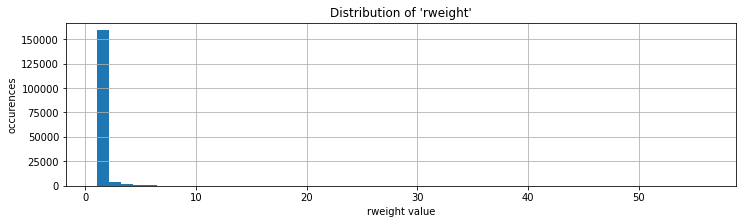

In [59]:
plt.figure(figsize=(12, 3))
plt.title("Distribution of 'rweight'")
plt.xlabel("rweight value")
plt.ylabel("occurences")
data.rweight.hist(bins=50)
plt.show()

What are the highest correlated variables with `rweight`?

In [60]:
threshold = 0.1
for label, correlation_score in data.corr().rweight.sort_values(ascending=False).iteritems():
    if abs(correlation_score) >= threshold and label != "rweight":
        print(f"{label} with {correlation_score:.2f} correlation score.")


resourceAllocationscore with 0.50 correlation score.
preferentialAttachmentscore with 0.32 correlation score.
adamicAdarscore with 0.29 correlation score.
p2pagerank with 0.22 correlation score.
commonNeighborsscore with 0.21 correlation score.
totalNeighborsscore with 0.18 correlation score.
p1pagerank with 0.17 correlation score.
p2betweennesscentrality with 0.14 correlation score.
p1betweennesscentrality with 0.10 correlation score.
ID(p1) with -0.11 correlation score.
topicsimilarity with -0.20 correlation score.


In [61]:
# Takes to long, we can consider doing something link sampling 10K rows
# plt.figure(figsize=(20,20))
# seaborn.clustermap(data.corr(), cmap=plt.cm.Reds) OR seaborn.clustermap(data.sample(10000), cmap=plt.cm.Reds)
# plt.show()

Correlation heatmap for variables (absolute correlation):

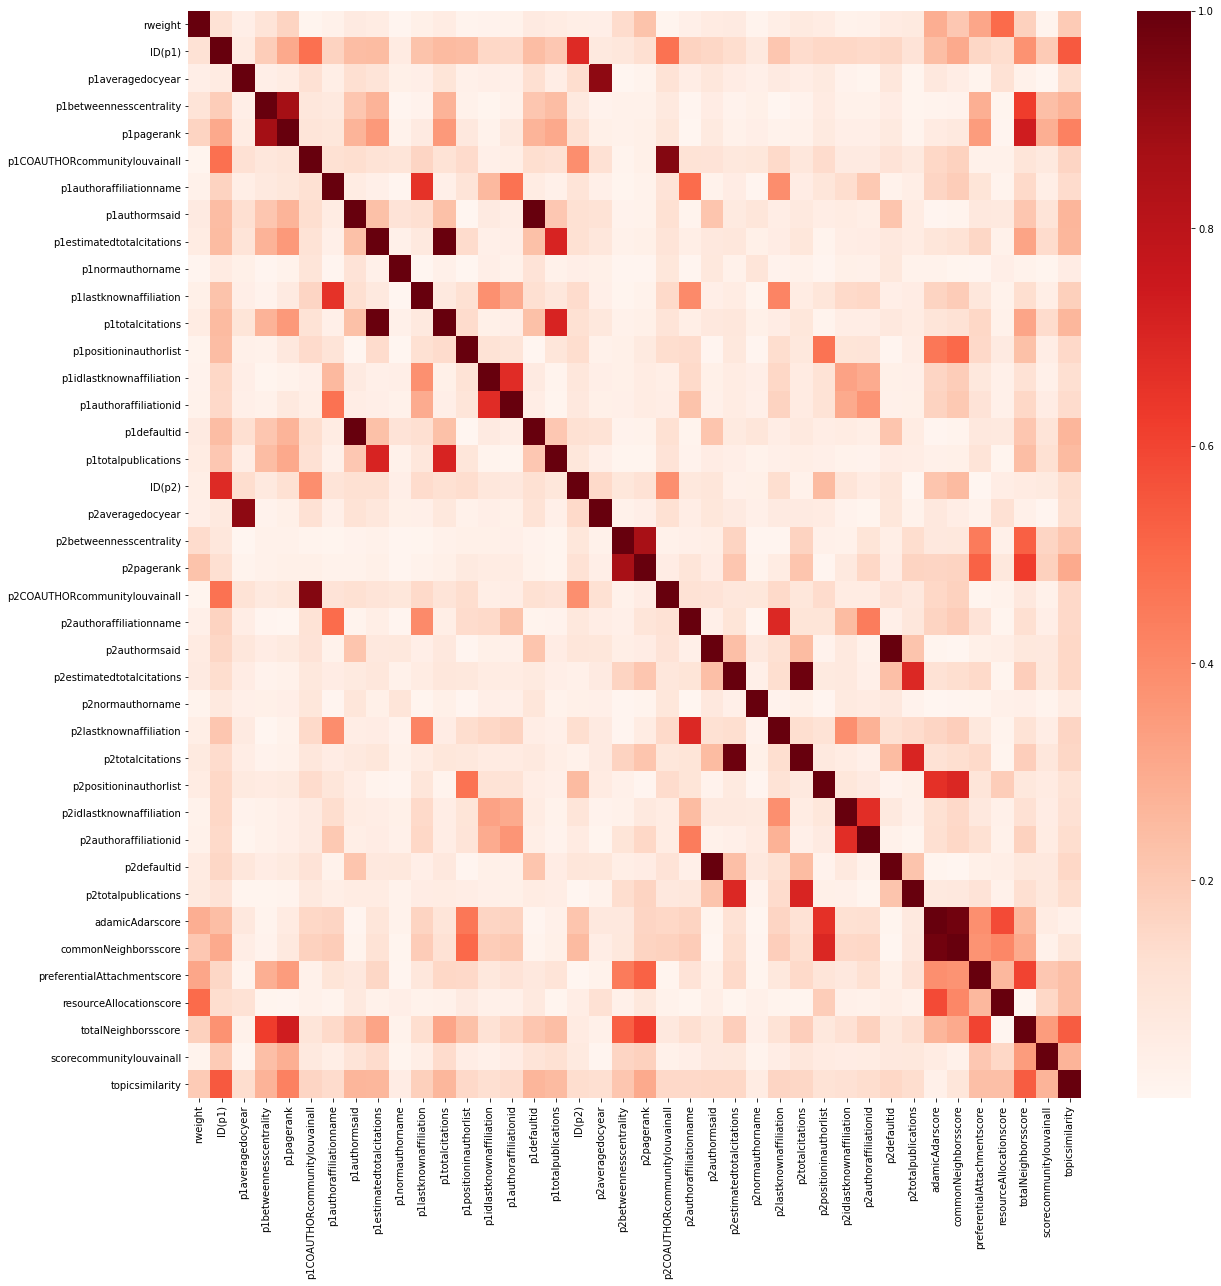

In [62]:
plt.figure(figsize=(20,20))
seaborn.heatmap(abs(data.corr()), cmap=plt.cm.Reds)
plt.show()

## 3.Create test and train set

We start be definning variables:

In [63]:
to_predict = "rweight" 
test_size = 0.33
shuffle = True
cross_validation_folds = 5

And we create our `X` and `y`:

In [64]:
# ONLY HIGHLY CORRELATED COLUMNS -> RESULTS ARE SIMILAR
# corr_thres = 0.2
# corr_columns = [column_name 
#                 for column_name in list(data) 
#                 if abs(data.rweight.corr(data[column_name])) > corr_thres 
#                 and column_name != "rweight"]
# X = data.loc[:, corr_columns]

X = data.loc[:, data.columns != to_predict]
y = data[to_predict]

As well as our train and test splits:

In [65]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                    y, 
                                                    test_size=test_size,  
                                                    shuffle=shuffle)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print()
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (111440, 39)
y_train: (111440,)

X_test: (54889, 39)
y_test: (54889,)


## [4.Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [66]:
model = "linear regression"

We fit a linear regression:

In [67]:
lr = linear_model.LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_test, y_pred, squared=False):.4f}")
print(f"R^2: {metrics.r2_score(y_test, y_pred):.4f}")

MAE: 0.4020
MSE: 0.5392
RMSE: 0.7343
R^2: 0.4006


Visualize predictions:

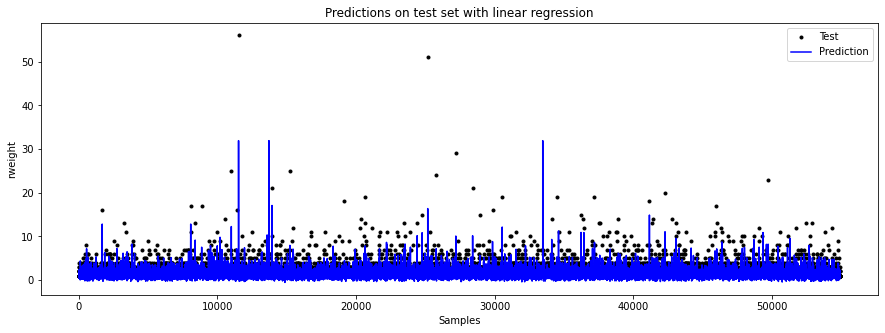

In [68]:
plt.figure(figsize=(15,5))
plt.title(f"Predictions on test set with {model}")
x_ax = range(len(X_test))
plt.plot(x_ax, y_test, ".", color='black', label="Test")
plt.ylabel(to_predict)
plt.xlabel("Samples")
plt.plot(x_ax, y_pred, color='blue', label="Prediction")
plt.legend()

What are the most important features? 

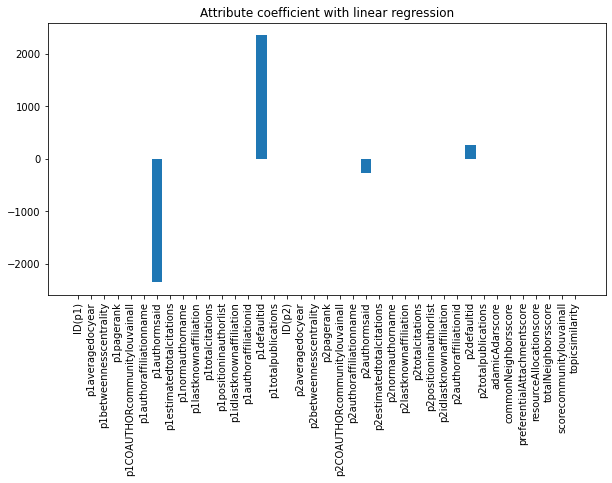

In [69]:
plt.figure(figsize=(10,5))
plt.title(f"Attribute coefficient with {model}")
coefs = dict(zip(list(X_train), lr.coef_))
plt.bar(range(len(coefs)), list(coefs.values()), align='center')
plt.xticks(range(len(coefs)), list(coefs.keys()), rotation=90)
plt.show()

## [5.ElasticNet with Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV)

In [70]:
model = "Elastic Net"

We fit an [Elastic Net Model](https://hackernoon.com/an-introduction-to-ridge-lasso-and-elastic-net-regression-cca60b4b934f)

Here are some `alpha` values we will use:

In [71]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.8]

In [72]:
elastic = linear_model.ElasticNetCV(alphas=alphas, cv=cross_validation_folds, tol=0.5).fit(X_train, y_train)
y_pred = elastic.predict(X_test)

print(f"Selected alpha from cross validation: {elastic.alpha_}")
print()
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_test, y_pred, squared=False):.4f}")
print(f"R^2: {metrics.r2_score(y_test, y_pred):.4f}")

Selected alpha from cross validation: 0.0001

MAE: 0.4132
MSE: 0.5739
RMSE: 0.7576
R^2: 0.3620


Visualize predictions:

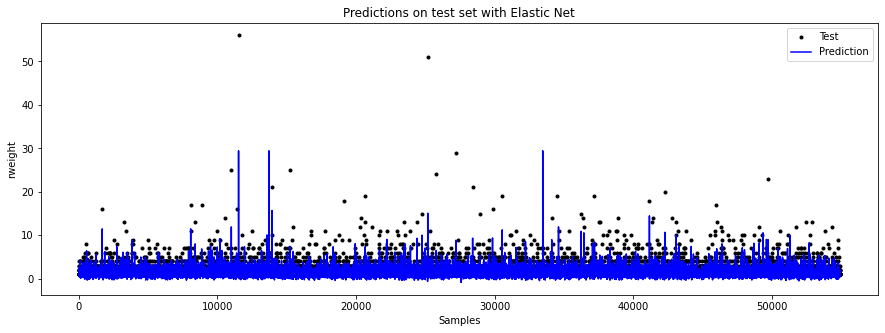

In [73]:
plt.figure(figsize=(15,5))
plt.title(f"Predictions on test set with {model}")
x_ax = range(len(X_test))
plt.plot(x_ax, y_test, ".", color='black', label="Test")
plt.ylabel(to_predict)
plt.xlabel("Samples")
plt.plot(x_ax, y_pred, color='blue', label="Prediction")
plt.legend()

What are the most important features? 

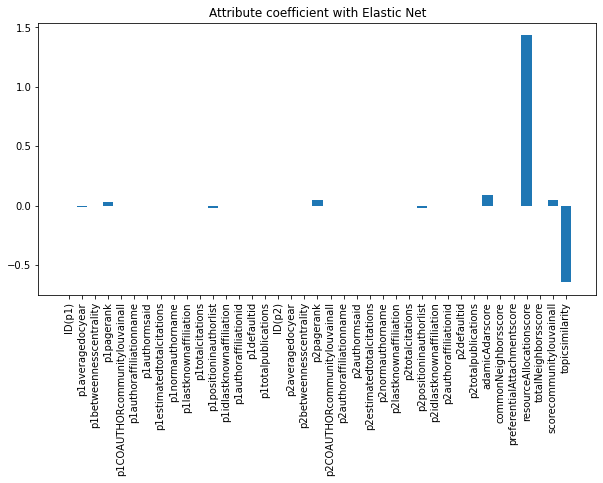

In [74]:
plt.figure(figsize=(10,5))
plt.title(f"Attribute coefficient with {model}")
coefs = dict(zip(list(X_train), elastic.coef_))
plt.bar(range(len(coefs)), list(coefs.values()), align='center')
plt.xticks(range(len(coefs)), list(coefs.keys()), rotation=90)
plt.show()

## [6.Neural Network Regression](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)

In [75]:
model = "MLP Regressor"

We fit a neural network

In [78]:
mlp = make_pipeline(preprocessing.StandardScaler(),
                    neural_network.MLPRegressor(hidden_layer_sizes=(100, 100),
                                 tol=1e-2, max_iter=500, random_state=0)).fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print(f"Selected alpha from cross validation: {elastic.alpha_}")
print()
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_test, y_pred, squared=False):.4f}")
print(f"R^2: {metrics.r2_score(y_test, y_pred):.4f}")

Selected alpha from cross validation: 0.0001

MAE: 0.2216
MSE: 0.3402
RMSE: 0.5833
R^2: 0.6218


Visualize predictions:

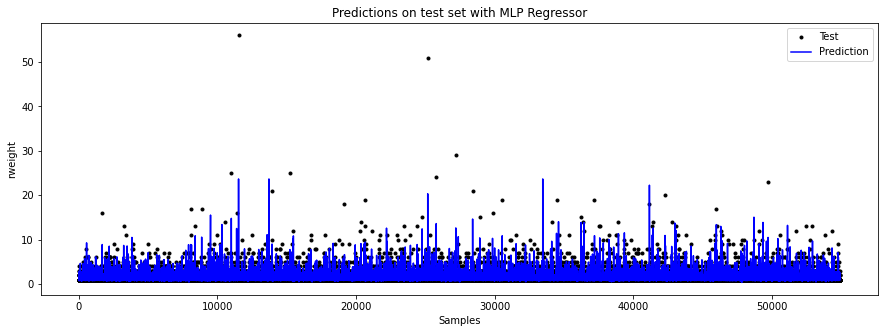

In [79]:
plt.figure(figsize=(15,5))
plt.title(f"Predictions on test set with {model}")
x_ax = range(len(X_test))
plt.plot(x_ax, y_test, ".", color='black', label="Test")
plt.ylabel(to_predict)
plt.xlabel("Samples")
plt.plot(x_ax, y_pred, color='blue', label="Prediction")
plt.legend()

What are the most important features? 

In [95]:
mlp.steps[1][1]

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=0, shuffle=True, solver='adam', tol=0.01,
             validation_fraction=0.1, verbose=False, warm_start=False)